## Problem description

### Static fracture opening under a constant pressure

Consider a line fracture $[-a_0, a_0] \times \{0\}$ ($a_0$ = 0.1) with no external loading and an internal fluid pressure of $p=1$  was applied to the fracture surfaces. The results are compared to the analytical solution (**Sneddon et al., 1969**) for the fracture half-opening:
\begin{eqnarray}
u(x,0) = \frac{2 p a_0}{ E'} \sqrt{1-(x/a_0)^2}
,
\label{eq:sneddon_2D_static}
\end{eqnarray}

where $u$ is the displacement $E'$ is the plane strain Young's modulus ($E' = E/(1-\nu^2)$) with $\nu$ is Poisson’s ratio, $p$ is the fluid pressure inside the fracture. To account for the infinite boundaries in the closed-form solution, we considered a large finite domain $ [-10a_o,10a_o] \times [-10a_o,10a_o]$. The effective element size, $h$, is $1\times10^{-2}$.


![Schematic view of Sneddon problem and Boundary conditions](./figures/Model_sneddon_straight.png#one-half "Schematic view of Sneddon problem and Boundary conditions.")

* In order to  have a static pressurized fracture, add, $\texttt{<pressurized_crack_scheme>static</pressurized_crack_scheme>}$ in the project file. It's important to note that static pressurized fracture implementation assumes $p=1$. **Yoshioka _et al._, 2019** discussed using real material properties and rescaling  the phase-field energy functional.


# Input data

The material and geometrical properties are listed in the Table below. It's worth noting that the properties are dimensionless and scaled.

| **Name**                       | **Value**         | **Symbol** |
|--------------------------------|------------------ |------------|
| _Young's modulus_              | 1                 | $E$        |
| _Poisson's ratio_              | 0.15              | $\nu$      |
| _Fracture toughness_           | 1                 | $G_{c}$    |
| _Regularization parameter_     | 2$h$              | $\ell_s$   |
| _Pressure_                     | 1                 | $p$        |
| _Length_                       | 2                 | $L$        |
| _Height_                       | 2                 | $H$        |
| _Initial crack length_         | 0.2               | $2a_0$     |

In [9]:
import math
import os
import time

import gmsh
import matplotlib.pyplot as plt
import numpy as np
import ogstools as ogs

pi = math.pi
plt.rcParams["text.usetex"] = True

In [10]:
E = 1.0
nu = 0.15
Gc = 1.0
P = 1.0
h = 0.01


Orientation = 0
a0 = 0.1  # half of the initial crack length
n_slices = (
    2 * (round(3.0 * a0 / h)) + 1
)  # number of slices for calcute width of fracture

phasefield_model = "AT1"

In [11]:
h_list = [0.01]  # list of mesh sizes (h)
# h_list =[0.01, 0.005, 0.0025]  # list of mesh sizes (h), for mesh sensitivity

# Output directory  and project file

In [12]:
# file's name
prj_name = "Kregime_Static.prj"
meshname = "mesh_full_pf"

from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

# Mesh generation


In [13]:
def mesh_generation(lc, lc_fine):
    """
    lc ... characteristic length for coarse meshing
    lc_fine ... characteristic length for fine meshing
    """
    L = 4.0  # Length
    H = 4.0  # Height
    b = 0.4  # Length/Height of subdomain with fine mesh

    # Before using any functions in the Python API, Gmsh must be initialized
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add("rectangle")

    # Dimensions
    dim1 = 1
    dim2 = 2

    # Points
    gmsh.model.geo.addPoint(-L / 2, -H / 2, 0, lc, 1)
    gmsh.model.geo.addPoint(L / 2, -H / 2, 0, lc, 2)
    gmsh.model.geo.addPoint(L / 2, H / 2, 0, lc, 3)
    gmsh.model.geo.addPoint(-L / 2, H / 2, 0, lc, 4)
    gmsh.model.geo.addPoint(-b, -b - lc_fine / 2, 0, lc_fine, 5)
    gmsh.model.geo.addPoint(b, -b - lc_fine / 2, 0, lc_fine, 6)
    gmsh.model.geo.addPoint(b, b + lc_fine / 2, 0, lc_fine, 7)
    gmsh.model.geo.addPoint(-b, b + lc_fine / 2, 0, lc_fine, 8)

    # Lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    gmsh.model.geo.addLine(5, 6, 5)
    gmsh.model.geo.addLine(6, 7, 6)
    gmsh.model.geo.addLine(7, 8, 7)
    gmsh.model.geo.addLine(8, 5, 8)

    # Line loops
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addCurveLoop([5, 6, 7, 8], 2)

    # Add plane surfaces defined by one or more curve loops.
    gmsh.model.geo.addPlaneSurface([1, 2], 1)
    gmsh.model.geo.addPlaneSurface([2], 2)

    gmsh.model.geo.synchronize()

    # Prepare structured grid
    gmsh.model.geo.mesh.setTransfiniteCurve(
        6, math.ceil(2 * b / lc_fine + 2), "Progression", 1
    )
    gmsh.model.geo.mesh.setTransfiniteCurve(
        8, math.ceil(2 * b / lc_fine + 2), "Progression", 1
    )
    gmsh.model.geo.mesh.setTransfiniteSurface(2, "Alternate")

    gmsh.model.geo.mesh.setRecombine(dim2, 1)
    gmsh.model.geo.mesh.setRecombine(dim2, 2)

    gmsh.model.geo.synchronize()

    # Physical groups
    Bottom = gmsh.model.addPhysicalGroup(dim1, [1])
    gmsh.model.setPhysicalName(dim1, Bottom, "Bottom")

    Right = gmsh.model.addPhysicalGroup(dim1, [2])
    gmsh.model.setPhysicalName(dim1, Right, "Right")

    Top = gmsh.model.addPhysicalGroup(dim1, [3])
    gmsh.model.setPhysicalName(dim1, Top, "Top")

    Left = gmsh.model.addPhysicalGroup(dim1, [4])
    gmsh.model.setPhysicalName(dim1, Left, "Left")

    Computational_domain = gmsh.model.addPhysicalGroup(dim2, [1, 2])
    gmsh.model.setPhysicalName(dim2, Computational_domain, "Computational_domain")
    gmsh.model.geo.synchronize()

    output_file = f"{out_dir}/" + meshname + ".msh"
    gmsh.model.mesh.generate(dim2)
    gmsh.write(output_file)
    gmsh.finalize()

# Pre process


In [14]:
def pre_processing(h, a0):
    mesh = pv.read(f"{out_dir}/mesh_full_pf_domain.vtu")
    phase_field = np.ones((len(mesh.points), 1))
    pv.set_plot_theme("document")

    for node_id, x in enumerate(mesh.points):
        if (
            (mesh.center[0] - x[0]) <= a0 + 0.001 * h
            and (mesh.center[0] - x[0]) >= -a0 - 0.001 * h
            and (mesh.center[1] - x[1]) < h / 2 + 0.001 * h
            and (mesh.center[1] - x[1]) > -h / 2 - 0.001 * h
        ):
            phase_field[node_id] = 0.0

    mesh.point_data["phase-field"] = phase_field
    mesh.save(f"{out_dir}/mesh_full_pf_OGS_pf_ic.vtu")

# Run the simulation 


In [15]:
import pyvista as pv

pv.set_plot_theme("document")
pv.set_jupyter_backend("static")


def sneddon_numerical(h):
    # mesh properties
    ls = 2 * h
    # generate prefix from properties
    filename = f"results_h_{h:0.4f}"
    mesh_generation(0.1, h)
    # Convert GMSH (.msh) meshes to VTU meshes appropriate for OGS simulation.
    input_file = f"{out_dir}/" + meshname + ".msh"  # noqa: F841
    ! msh2vtu --keep_ids -o {out_dir} {input_file}
    # As a preprocessing step, define the initial phase-field (crack).
    pre_processing(h, a0)
    # change properties in prj file #For more information visit: https://ogstools.opengeosys.org/stable/reference/ogstools.ogs6py.html
    model = ogs.Project(
        input_file=prj_name,
        output_file=f"{out_dir}/{prj_name}",
        MKL=True,
        args=f"-o {out_dir}",
    )

    gml_file = Path("./Kregime_Static.gml").resolve()

    model.replace_parameter_value(name="ls", value=ls)
    model.replace_text(gml_file, xpath="./geometry")
    model.replace_text(filename, xpath="./time_loop/output/prefix")
    model.write_input()
    # run simulation with ogs
    t0 = time.time()
    print(">>> OGS started execution ... <<<")

    !ogs {out_dir}/{prj_name} -o {out_dir} -m {out_dir} > {out_dir}/ogs-out.txt
    assert _exit_code == 0  # noqa: F821
    tf = time.time()
    print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

In [18]:
for h_j in h_list:
    sneddon_numerical(h=h_j)

[2022-12-12 13:24:30.160] [ogs] [warning] Array 'vtkOriginalPointIds' in VTU file uses unsupported data type 'idtype' of size 8. The data array will not be available.
[2022-12-12 13:24:30.161] [ogs] [warning] Array 'vtkOriginalCellIds' in VTU file uses unsupported data type 'idtype' of size 8. The data array will not be available.
[2022-12-12 13:24:30.161] [ogs] [info] Reordering nodes... 
[2022-12-12 13:24:30.172] [ogs] [info] Corrected 0 elements.
[2022-12-12 13:24:30.209] [ogs] [info] VTU file written.
>>> OGS started execution ... <<<
>>> OGS terminated execution  <<< Elapsed time:  307.0  s.


# Post processing 

In [19]:
# As a post-process, we calculate the fracture opening.
def width_calculation(filename):
    reader = pv.get_reader(f"{out_dir}/{filename}.pvd")
    # --------------------------------------------------------------------------------
    # Active the results of last time step
    # --------------------------------------------------------------------------------
    reader.set_active_time_value(reader.time_values[-1])
    mesh = reader.read()[0]
    # --------------------------------------------------------------------------------
    # define grad d
    # --------------------------------------------------------------------------------
    mesh_d = mesh.compute_derivative(scalars="phasefield")
    mesh_d["gradient"]

    def gradients_to_dict(arr):
        """A helper method to label the gradients into a dictionary."""
        keys = np.array(
            ["grad_dx", "grad_dy", "grad_dz", "grad_dx", "grad_dy", "grad_dz"]
        )
        keys = keys.reshape((2, 3))[:, : arr.shape[1]].ravel()
        return dict(zip(keys, mesh_d["gradient"].T))

    gradients_d = gradients_to_dict(mesh_d["gradient"])
    mesh.point_data.update(gradients_d)
    # --------------------------------------------------------------------------------
    # define width at nodes
    # --------------------------------------------------------------------------------
    disp = mesh.point_data["displacement"]
    grad_dx = mesh.point_data["grad_dx"]
    grad_dy = mesh.point_data["grad_dy"]
    num_points = disp.shape
    Wnode = np.zeros(num_points[0])
    for i, _x in enumerate(mesh.points):
        u_x = disp[i][0]
        u_y = disp[i][1]
        gd_x = grad_dx[i]
        gd_y = grad_dy[i]

        Wnode[i] = 0.5 * (u_x * gd_x + u_y * gd_y)
    mesh.point_data["Wnode"] = Wnode
    # --------------------------------------------------------------------------------
    # define width at nodes
    # --------------------------------------------------------------------------------
    # Normalize the vector
    normal = [np.cos(Orientation), np.sin(Orientation), 0]
    # Make points along that vector for the extent of your slices
    point_a = mesh.center + np.array([1.5 * a0, 0, 0])
    point_b = mesh.center + np.array([-1.5 * a0, 0, 0])
    dist_a_b = ((point_b[0] - point_a[0]) ** 2 + (point_b[1] - point_a[1]) ** 2) ** 0.5
    # Define the line/points for the slices
    line = pv.Line(point_a, point_b, n_slices)
    width_line = np.zeros(len(line.points))
    r_i = np.zeros(len(line.points))
    # Generate all of the slices
    slices = pv.MultiBlock()

    for i, point in enumerate(line.points):
        slices.append(mesh.slice(normal=normal, origin=point))
        slice_mesh = mesh.slice(normal=normal, origin=point)
        y_slice = slice_mesh.points[:, 1]
        Wnode_slice = slice_mesh.point_data["Wnode"]
        width_i = np.trapz(Wnode_slice, x=y_slice)  # noqa: NPY201
        if width_i >= 0:
            width_line[i] = width_i
        r_i[i] = (
            (point[0] - point_a[0]) ** 2 + (point[1] - point_a[1]) ** 2
        ) ** 0.5 - dist_a_b / 2

    return r_i, width_line

# Sneddon

In [20]:
def sneddon(h, ls, phasefield_model):
    # Effective a for AT1/A2
    if phasefield_model == "AT1":
        a_eff = a0 * (1 + pi * ls / (4.0 * a0 * (3 * h / 8.0 / ls + 1.0)))
    elif phasefield_model == "AT2":
        a_eff = a0 * (1 + pi * ls / (4.0 * a0 * (h / (2.0 * ls) + 1.0)))

    x = np.linspace(-1.0 * a_eff, a_eff, 40)
    uy = []
    for i in range(len(x)):
        uy.append(
            2 * a_eff * (1 - nu**2) * P / E * math.sqrt(1.0 - ((x[i]) / (a_eff)) ** 2)
        )

    return x, uy, a_eff

## Opening profile

results_h_0.0100


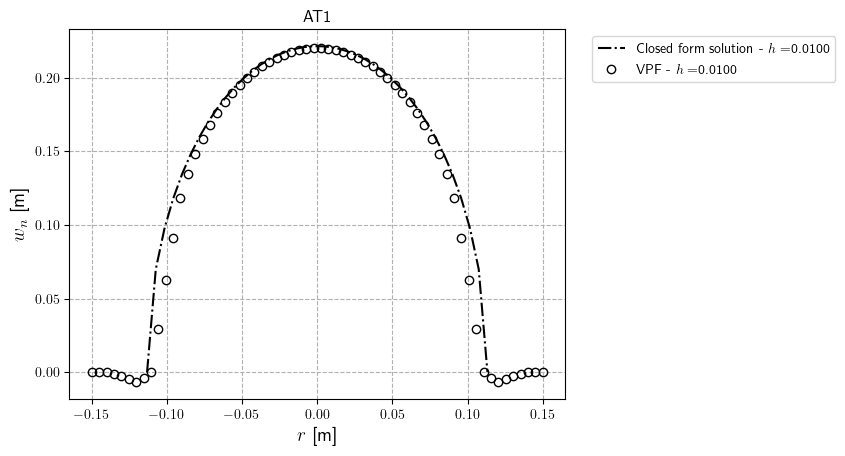

In [21]:
color = ["-.k", "ko", "-.r", "ro", "-.b", "bo", "-.g", "go"]
Label = ["Closed form solution", "VPF-FEM"]
lineWIDTH = [1.5, 1.5, 1.5]

for j, h_j in enumerate(h_list):
    r_i_num = []
    width_line_num = []
    filename = f"results_h_{h_j:0.4f}"
    print(filename)
    width_calculation(filename)
    r_i_num = width_calculation(filename)[0]
    width_line_num = width_calculation(filename)[1]
    ls = 2 * h_j

    x_Sneddon = sneddon(h_j, ls, phasefield_model)[0]
    uy_Sneddon = sneddon(h_j, ls, phasefield_model)[1]
    a_eff_Sneddon = sneddon(h_j, ls, phasefield_model)[2]
    plt.plot(
        np.array(x_Sneddon[:]),
        np.array(uy_Sneddon[:]),
        color[2 * j],
        fillstyle="none",
        markersize=0,
        linewidth=lineWIDTH[0],
        label=f"Closed form solution - $h= ${h_j:0.4f}",
    )
    plt.plot(
        np.array(r_i_num[:]),
        np.array(width_line_num[:]),
        color[2 * j + 1],
        fillstyle="none",
        markersize=6,
        linewidth=lineWIDTH[1],
        label=f"VPF - $h =${h_j:0.4f}",
    )
    # ------------------------------------------------------------------------
plt.rcParams["figure.figsize"] = [40, 20]
plt.rcParams["figure.dpi"] = 1600
plt.ylabel("$w_n$ [m]", fontsize=14)
plt.xlabel("$r$ [m]", fontsize=14)
plt.grid(linestyle="dashed")
plt.title(f"{phasefield_model}")

legend = plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

To decrease computing time, we perform the simulation with an one coarse mesh; Mesh sensitivity can be investigated in order to assess the convergence of the opening profile for various mesh discretizations. Following are the mesh sensivity results for for Models $\texttt{AT}_1$ and $\texttt{AT}_2$ ($h=0.01,~0.005,~\text{and} ~0.0025$ m.)

![Crack opening profiles of  VPF ($\texttt{AT}_1$) with different mesh sizes compared against the Sneddon solution.](./figures/AT1_crackopening_mesh_sensitivity.png#one-half "Crack opening profiles of  VPF ($\texttt{AT}_1$) with different mesh sizes compared against the Sneddon solution.")
![Crack opening profiles of  VPF ($\texttt{AT}_2$) with different mesh sizes compared against the Sneddon solution.](./figures/AT2_crackopening_mesh_sensitivity.png#one-half "Crack opening profiles of VPF ($\texttt{AT}_2$) with different mesh sizes compared against the Sneddon solution.")


Our mesh size sensitivity study shows even with coarse mesh. The results away from crack tips agree well with the Sneddon solution. Using finer mesh demonstrates that the opening along the whole crack length is accurate compared with the closed-form solution.

It's worth noting that we estimate width as part of post-processing (using the line integral and a given crack normal vector). However, near crack tips the crack normal vector is different to the given normal vector, so the width values are inaccurate near crack tips. For the sake of simplicity, we neglect determining the normal crack vector here; for more information on the line integral approach, see **Yoshioka et al., 2020**.

## References

[1]  Yoshioka, Keita, Francesco Parisio, Dmitri Naumov, Renchao Lu, Olaf Kolditz, and Thomas Nagel. _Comparative verification of discrete and smeared numerical approaches for the simulation of hydraulic fracturing._ GEM-International Journal on Geomathematics **10**, no. 1 (2019): 1-35.

[2] Yoshioka, Keita, Dmitri Naumov, and Olaf Kolditz. _On crack opening computation in variational phase-field models for fracture._ Computer Methods in Applied Mechanics and Engineering 369 (2020): 113210.

[3] Sneddon, Ian Naismith, and Morton Lowengrub. _Crack problems in the classical theory of elasticity._ 1969, 221 P (1969).
